In [27]:
# Importations standard et pour la manipulation des données
import os
import pandas as pd
import numpy as np
from datetime import datetime
from cmath import phase, rect
from math import radians, degrees

# Importations pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Importations pour le machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Configuration de Seaborn pour les visualisations
sns.set(style="whitegrid")

# Ignorer les avertissements inutiles pour nettoyer la sortie
import warnings
warnings.filterwarnings("ignore")


In [28]:
path = "./data/"

general_data = pd.read_csv(path + "general_data.csv")
employe_data = pd.read_csv(path + "employee_survey_data.csv")
manager_data = pd.read_csv(path + "manager_survey_data.csv")
In_data = pd.read_csv(path + "in_time.csv")
Out_data = pd.read_csv(path + "out_time.csv")

general = general_data.copy()
employe = employe_data.copy()
manager = manager_data.copy()
In = In_data.copy()
Out = Out_data.copy()
In

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,NaN,2015-01-02 09:20:32,2015-01-05 10:17:53,2015-01-06 10:26:51,2015-01-07 10:06:58,2015-01-08 09:45:06,2015-01-09 09:49:24,2015-01-12 09:37:10,2015-01-13 09:25:02,...,2015-12-18 10:01:06,2015-12-21 10:25:25,2015-12-22 10:16:11,2015-12-23 10:04:40,2015-12-24 09:45:40,NaN,2015-12-28 10:15:39,2015-12-29 10:10:09,2015-12-30 09:28:19,2015-12-31 10:00:12
4406,4407,NaN,2015-01-02 10:03:41,NaN,2015-01-06 09:44:00,2015-01-07 09:42:10,2015-01-08 10:00:57,2015-01-09 09:44:04,2015-01-12 10:07:32,2015-01-13 10:05:11,...,2015-12-18 09:27:32,2015-12-21 09:41:24,2015-12-22 09:50:30,2015-12-23 10:32:21,2015-12-24 09:47:41,NaN,2015-12-28 09:54:23,2015-12-29 10:13:32,2015-12-30 10:21:09,2015-12-31 10:09:48
4407,4408,NaN,2015-01-02 10:01:01,2015-01-05 09:33:00,2015-01-06 09:49:17,2015-01-07 10:28:12,2015-01-08 09:47:38,2015-01-09 10:01:03,2015-01-12 09:49:12,2015-01-13 09:47:10,...,2015-12-18 10:00:57,2015-12-21 09:51:07,2015-12-22 10:02:10,2015-12-23 09:58:29,2015-12-24 09:56:05,NaN,2015-12-28 09:59:24,NaN,2015-12-30 10:02:36,2015-12-31 10:03:30
4408,4409,NaN,2015-01-02 10:17:05,2015-01-05 10:02:27,2015-01-06 10:12:50,2015-01-07 10:12:31,2015-01-08 09:42:57,NaN,2015-01-12 10:00:38,2015-01-13 09:48:03,...,2015-12-18 09:54:33,2015-12-21 10:01:08,2015-12-22 10:10:19,2015-12-23 09:42:30,2015-12-24 09:56:05,NaN,2015-12-28 09:55:25,2015-12-29 09:54:42,2015-12-30 10:15:44,2015-12-31 09:56:47


In [29]:
for col in general.columns:
    value = general[col].nunique()
    value_of = general[col].unique()
    if value == 1:
        print(col)
        print(value_of)

EmployeeCount
[1]
Over18
['Y']
StandardHours
[8]


In [30]:
general = general.drop(columns=['EmployeeCount','Over18'])

In [31]:
In.fillna(0, inplace=True)
Out.fillna(0, inplace=True)
vac_In = (In == 0).astype(int).sum(axis=1)
vac_Out = (Out ==0).astype(int).sum(axis=1)

vac_In.equals(vac_Out)


True

In [32]:
In = In.drop(In.columns[0], axis = 1)
Out = Out.drop(Out.columns[0], axis = 1)

In [33]:
In_h = In.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))
Out_h = Out.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))

def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def mean_time(row):
    row = row.dropna()  # Supprimer les valeurs NaT
    if row.empty:
        return None  # Retourner None ou une valeur par défaut si la ligne est vide après la suppression des NaT
    t = ([time.hour, time.minute, time.second] for time in row)
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    seconds = [i for i in seconds if i > 0]
    if not seconds:
        return None  # Retourner None ou une valeur par défaut si aucun second n'est > 0
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    return '%02i:%02i:%02i' % (h, m, s)

In_h['AverageInTime'] = In_h.apply(mean_time, axis=1)
Out_h['AverageOutTime'] = Out_h.apply(mean_time, axis=1)  # Correction du nom de colonne pour AverageOutTime


In [34]:
In_h['AverageInTime'].head()

0    10:00:05
1    09:59:17
2    10:01:30
3    09:58:54
4    09:59:54
Name: AverageInTime, dtype: object

In [35]:
Average_Out = pd.to_timedelta(Out_h['AverageOutTime'])
Average_In = pd.to_timedelta(In_h['AverageInTime'])

AverageTimeWorking = (Average_Out - Average_In)

print(AverageTimeWorking)

0      0 days 07:22:25
1      0 days 07:43:08
2      0 days 07:00:47
3      0 days 07:11:37
4      0 days 08:00:21
             ...      
4405   0 days 08:31:20
4406   0 days 06:05:34
4407   0 days 07:42:24
4408   0 days 09:29:34
4409   0 days 06:59:20
Length: 4410, dtype: timedelta64[ns]


In [36]:
combined = general.merge(manager, how='right', on = 'EmployeeID')
combined_csv = combined.merge(employe, how='right', on = 'EmployeeID')
#On transforme tous les NA en 0
combined_csv.fillna(0, inplace=True)
combined_csv['AverageTimeWorking'] = AverageTimeWorking
combined_csv['Holidays'] = vac_In

combined_csv['AverageInTime'] = Average_In
combined_csv['AverageOutTime'] = Average_Out

combined_csv

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,0,3,3,3.0,4.0,2.0,0 days 07:22:25,29,0 days 10:00:05,0 days 17:22:30
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,4,2,4,3.0,2.0,4.0,0 days 07:43:08,25,0 days 09:59:17,0 days 17:42:25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,3,3,3,2.0,2.0,1.0,0 days 07:00:47,19,0 days 10:01:30,0 days 17:02:17
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,5,2,3,4.0,4.0,3.0,0 days 07:11:37,26,0 days 09:58:54,0 days 17:10:31
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,4,3,3,4.0,1.0,3.0,0 days 08:00:21,16,0 days 09:59:54,0 days 18:00:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,2,3,3,4.0,1.0,3.0,0 days 08:31:20,18,0 days 10:01:11,0 days 18:32:31
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,2,2,3,4.0,4.0,3.0,0 days 06:05:34,20,0 days 10:00:15,0 days 16:05:49
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,2,3,4,1.0,3.0,3.0,0 days 07:42:24,30,0 days 09:58:47,0 days 17:41:11
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,8,2,3,4.0,1.0,3.0,0 days 09:29:34,20,0 days 10:01:06,0 days 19:30:40


In [37]:
Time_float = combined_csv['AverageTimeWorking'].dt.seconds
Time_float = Time_float/3600
print(Time_float)
combined_csv['AverageTimeWorking'] = Time_float

Time_float = combined_csv['AverageInTime'].dt.seconds
Time_float = Time_float/3600
print(Time_float)
combined_csv['AverageInTime'] = Time_float

Time_float = combined_csv['AverageOutTime'].dt.seconds
Time_float = Time_float/3600
print(Time_float)
combined_csv['AverageOutTime'] = Time_float

0       7.373611
1       7.718889
2       7.013056
3       7.193611
4       8.005833
          ...   
4405    8.522222
4406    6.092778
4407    7.706667
4408    9.492778
4409    6.988889
Name: AverageTimeWorking, Length: 4410, dtype: float64
0       10.001389
1        9.988056
2       10.025000
3        9.981667
4        9.998333
          ...    
4405    10.019722
4406    10.004167
4407     9.979722
4408    10.018333
4409    10.017778
Name: AverageInTime, Length: 4410, dtype: float64
0       17.375000
1       17.706944
2       17.038056
3       17.175278
4       18.004167
          ...    
4405    18.541944
4406    16.096944
4407    17.686389
4408    19.511111
4409    17.006667
Name: AverageOutTime, Length: 4410, dtype: float64


In [38]:
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeID               4410 non-null   int64  
 8   Gender                   4410 non-null   object 
 9   JobLevel                 4410 non-null   int64  
 10  JobRole                  4410 non-null   object 
 11  MaritalStatus            4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4410 non-null   float64
 14  PercentSalaryHike       

In [39]:
combined_csv['AverageTimeWorking'].describe()

count    4410.000000
mean        7.700789
std         1.340222
min         5.950556
25%         6.673333
50%         7.406667
75%         8.368611
max        11.031389
Name: AverageTimeWorking, dtype: float64

In [40]:
WorkingTimeEval = []
for i in range (0, combined_csv.shape[0]):
    if combined_csv['AverageTimeWorking'][i] < combined_csv['StandardHours'][i] :
        WorkingTimeEval.append(0)
    elif (combined_csv['AverageTimeWorking'][i] >= combined_csv['StandardHours'][i]) and (combined_csv['AverageTimeWorking'][i] <= 9):
        WorkingTimeEval.append(1)
    elif combined_csv['AverageTimeWorking'][i] > 9 :
        WorkingTimeEval.append(2)

In [41]:
combined_csv['WorkingTimeEval'] = WorkingTimeEval
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeID               4410 non-null   int64  
 8   Gender                   4410 non-null   object 
 9   JobLevel                 4410 non-null   int64  
 10  JobRole                  4410 non-null   object 
 11  MaritalStatus            4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4410 non-null   float64
 14  PercentSalaryHike       

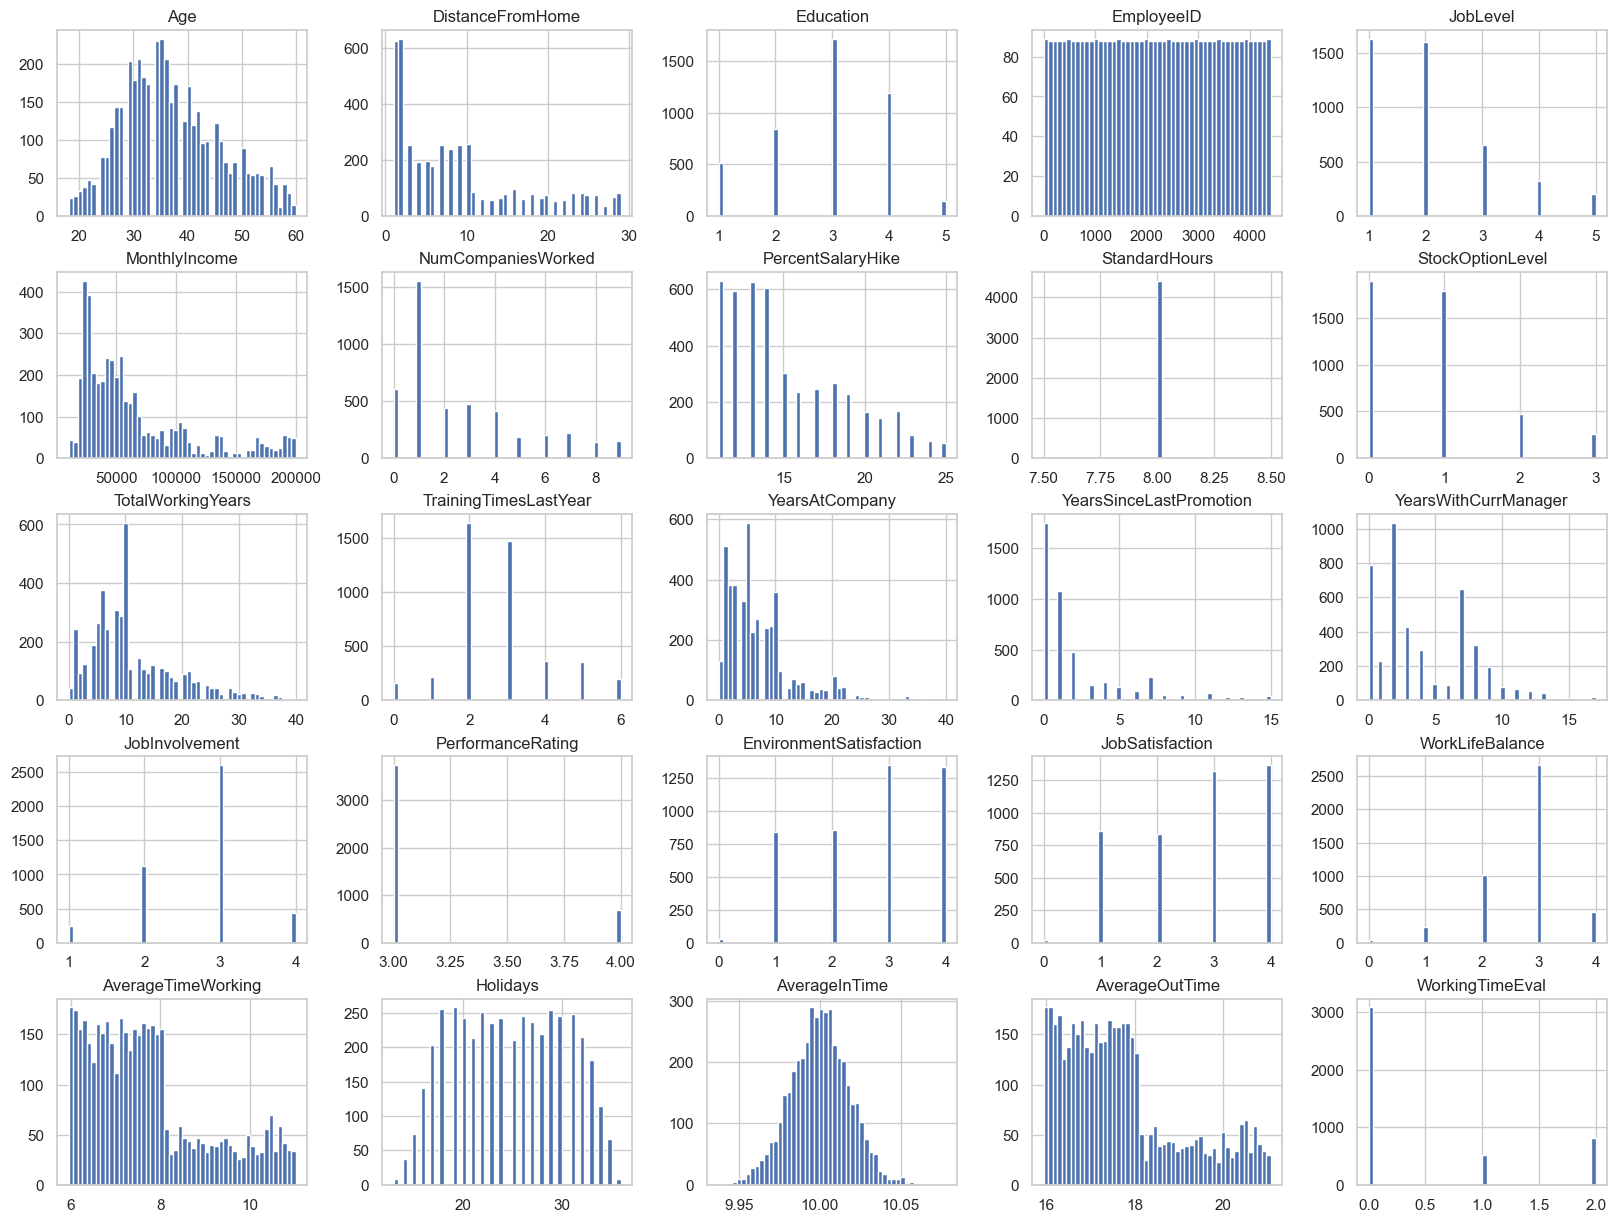

In [56]:
combined_csv.hist(bins=50, figsize=(20,15))
plt.show()

In [43]:
# Identification des colonnes pour chaque transformation
num_features = ['MonthlyIncome', 'DistanceFromHome', 'TotalWorkingYears', 'NumCompaniesWorked', 'YearsAtCompany', 'Holidays', 'AverageTimeWorking', 'AverageInTime', 'AverageOutTime', 'WorkingTimeEval']
cat_features = ['BusinessTravel','Department' , 'EducationField', 'JobRole']

# Création des pipelines pour les transformations numériques et catégorielles
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Assemblage du pipeline complet
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Division du dataset
X = combined_csv.drop('Attrition', axis=1)
y = combined_csv['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # Conversion de la cible en binaire


# Vérifiez si toutes les colonnes référencées existent dans X
print(X.columns)
missing_cols_num = [col for col in num_features if col not in X.columns]
missing_cols_cat = [col for col in cat_features if col not in X.columns]
print("Colonnes numériques manquantes:", missing_cols_num)
print("Colonnes catégorielles manquantes:", missing_cols_cat)

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement',
       'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'AverageTimeWorking', 'Holidays', 'AverageInTime',
       'AverageOutTime', 'WorkingTimeEval'],
      dtype='object')
Colonnes numériques manquantes: []
Colonnes catégorielles manquantes: []


## Algorithmes de Machine Learning 
Notre pipeline de prétraitement des données est désormais prêt, intégrant soigneusement les transformations nécessaires pour les caractéristiques numériques et catégorielles. Cette étape cruciale nous permet d'assurer que les données sont correctement formatées et normalisées pour l'application des modèles d'apprentissage automatique. Avec cette préparation achevée, nous pouvons maintenant passer à la phase suivante de notre projet : la sélection et l'application des algorithmes de machine learning. 

## Méthode des k plus proches voisins (KNN)
La méthode des k plus proches voisins (KNN) est un algorithme d'apprentissage supervisé simple et intuitif utilisé pour la classification et la régression. Le principe de base de KNN est de trouver les k échantillons les plus proches (ou voisins) d'un point de données non classifié dans l'espace des caractéristiques et de prédire son étiquette (pour la classification) ou sa valeur (pour la régression) en se basant sur la majorité ou la moyenne des étiquettes ou valeurs de ces voisins. La distance entre les points de données, souvent calculée par la distance euclidienne, sert à déterminer les voisins les plus proches. L'efficacité de KNN dépend du choix de k (le nombre de voisins) et de la mesure de distance utilisée. Bien qu'il soit facile à comprendre et à mettre en œuvre, KNN peut devenir inefficace en termes de temps et de mémoire avec de grands ensembles de données, car il nécessite de calculer la distance à chaque point de données lors de la prédiction.

### Copie des données

In [44]:
dataSetKNN = combined_csv.copy()
dataSetKNN

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


In [45]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [46]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du pipeline
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', KNeighborsClassifier())])

In [47]:
# Prédictions sur l'ensemble de test
y_pred = knn_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8624338624338624

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1115
           1       0.63      0.31      0.41       208

    accuracy                           0.86      1323
   macro avg       0.75      0.64      0.67      1323
weighted avg       0.84      0.86      0.84      1323



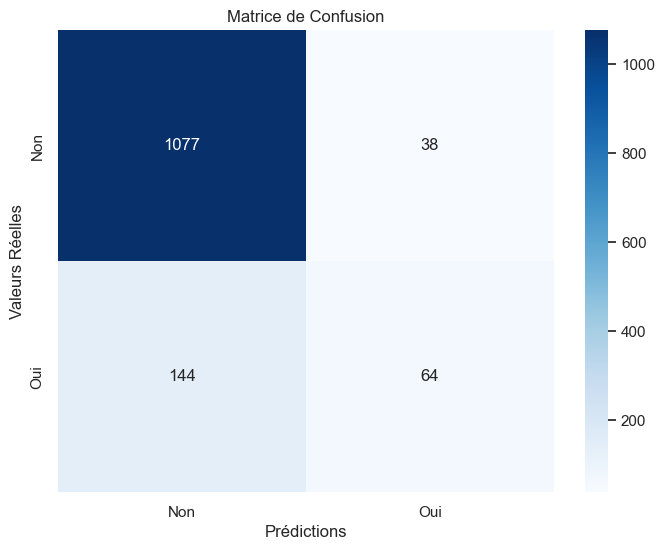

In [48]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

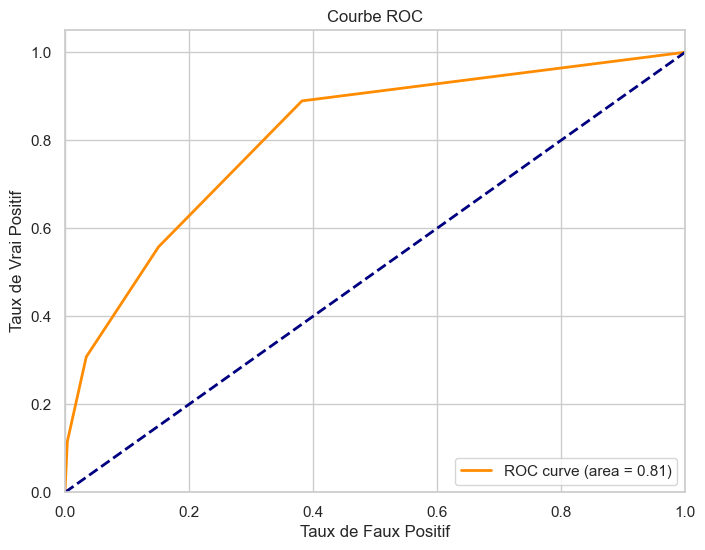

In [49]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, knn_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## Random Forest
Random Forest est un algorithme d'apprentissage supervisé polyvalent et robuste utilisé pour la classification et la régression. Il fonctionne en construisant un grand nombre d'arbres de décision lors de la phase d'entraînement et en produisant la classe qui est le mode des classes (classification) ou la moyenne des prédictions (régression) des arbres individuels. Random Forest est un exemple d'ensemble learning, où la combinaison des résultats de multiples modèles vise à produire une prédiction finale plus précise et plus stable.

Un des principaux avantages de Random Forest est sa capacité à gérer un grand nombre de caractéristiques d'entrée et à évaluer l'importance de chaque caractéristique dans la prédiction. Cela en fait un choix excellent pour les situations où la compréhension des facteurs influents est aussi importante que la prédiction elle-même. De plus, Random Forest a tendance à éviter le surajustement aux données d'entraînement grâce à la diversité des arbres et à l'utilisation de sous-ensembles aléatoires de caractéristiques pour diviser les noeuds des arbres, ce qui le rend généralement performant sur des ensembles de données non vus.

Avec sa facilité d'utilisation et sa nature peu exigeante en termes de réglage des hyperparamètres, Random Forest est souvent un bon point de départ pour les tâches de modélisation prédictive et peut servir de benchmark pour comparer les performances avec d'autres algorithmes de machine learning.

In [50]:
dataSetforest = combined_csv.copy()
dataSetforest

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


In [51]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [52]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du pipeline
random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [57]:
# Prédictions sur l'ensemble de test
y_pred = random_forest_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9380196523053665

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1115
           1       1.00      0.61      0.75       208

    accuracy                           0.94      1323
   macro avg       0.97      0.80      0.86      1323
weighted avg       0.94      0.94      0.93      1323



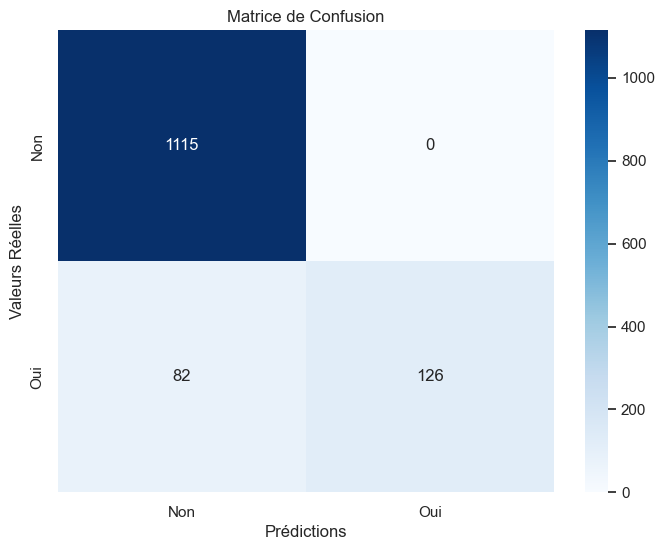

In [58]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

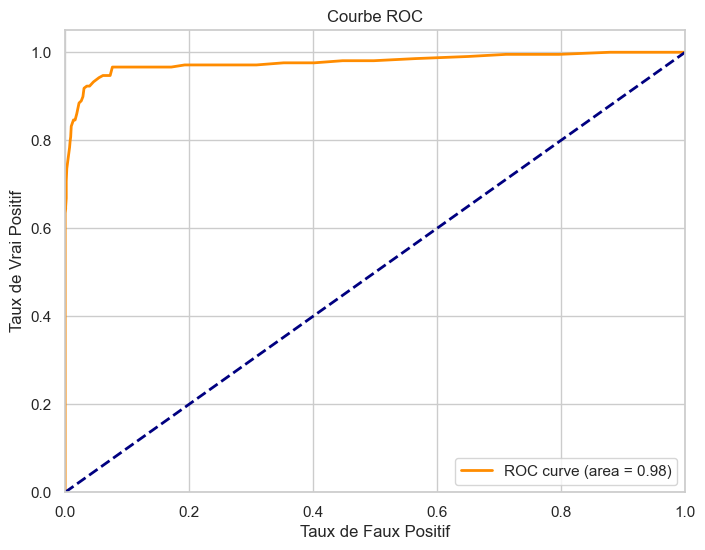

In [59]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, random_forest_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## Regression Linéaire

La régression linéaire est une méthode statistique utilisée pour modéliser la relation entre une variable dépendante et une ou plusieurs variables indépendantes. Contrairement à la méthode des k plus proches voisins (KNN) qui est basée sur la proximité et la majorité ou moyenne des voisins pour la classification ou la régression, la régression linéaire cherche à établir une équation linéaire qui prédit la variable dépendante en fonction des variables indépendantes.tes.

In [60]:
dataSetLinearRegression = combined_csv.copy()
dataSetLinearRegression

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


In [61]:
# Création d'un pipeline intégrant le préprocesseur et le modèle de régression logistique
linear_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [62]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrainement du pipeline
linear_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [63]:
# Prédictions sur l'ensemble de test
y_pred = linear_regression_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8586545729402872

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92      1115
           1       0.70      0.18      0.28       208

    accuracy                           0.86      1323
   macro avg       0.78      0.58      0.60      1323
weighted avg       0.84      0.86      0.82      1323



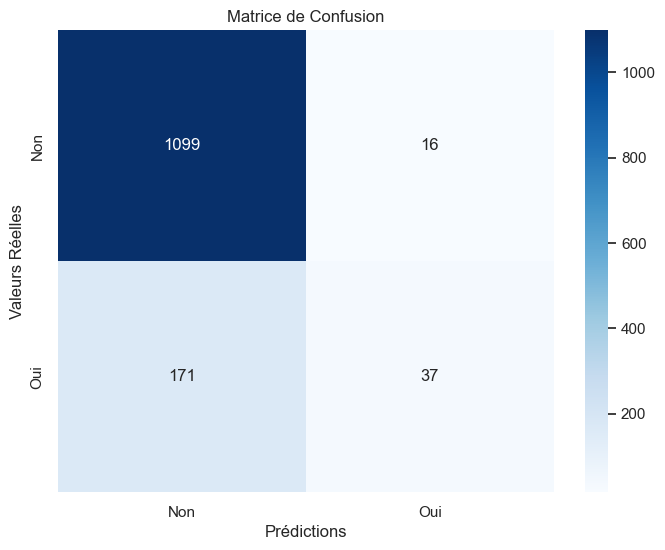

In [64]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

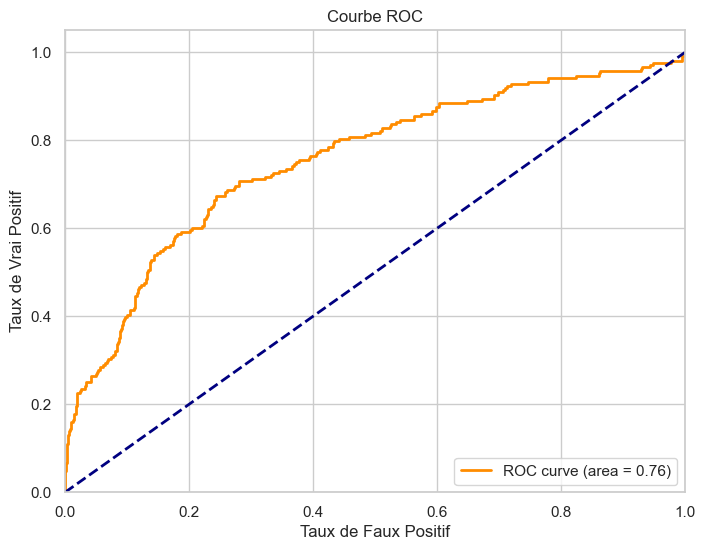

In [65]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, linear_regression_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## Perceptron


BLA BLA BLA sur le Perceptron

In [66]:
dataSetPerceptron = combined_csv.copy()
dataSetPerceptron

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,AverageInTime,AverageOutTime,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,3,3,3.0,4.0,2.0,7.373611,29,10.001389,17.375000,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,2,4,3.0,2.0,4.0,7.718889,25,9.988056,17.706944,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,3,3,2.0,2.0,1.0,7.013056,19,10.025000,17.038056,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,2,3,4.0,4.0,3.0,7.193611,26,9.981667,17.175278,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,3,3,4.0,1.0,3.0,8.005833,16,9.998333,18.004167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,3,3,4.0,1.0,3.0,8.522222,18,10.019722,18.541944,1
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,2,3,4.0,4.0,3.0,6.092778,20,10.004167,16.096944,0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,3,4,1.0,3.0,3.0,7.706667,30,9.979722,17.686389,0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,2,3,4.0,1.0,3.0,9.492778,20,10.018333,19.511111,2


In [67]:
perceptron_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Perceptron(max_iter=1000, tol=1e-3))
])

In [68]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrainement du pipeline
perceptron_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking',
                                                   'AverageInTime',
                                                   'AverageOutTime',
                                                   'WorkingTimeEval']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField',
                                                   'JobRole'])])),
                ('classifier', Perceptron())])

In [69]:
# Prédictions sur l'ensemble de test
y_pred = perceptron_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7331821617535903

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1115
           1       0.19      0.22      0.20       208

    accuracy                           0.73      1323
   macro avg       0.52      0.52      0.52      1323
weighted avg       0.75      0.73      0.74      1323



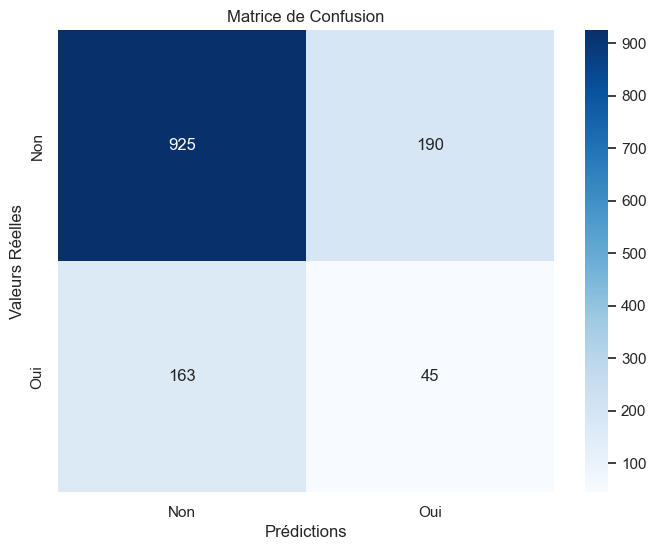

In [70]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

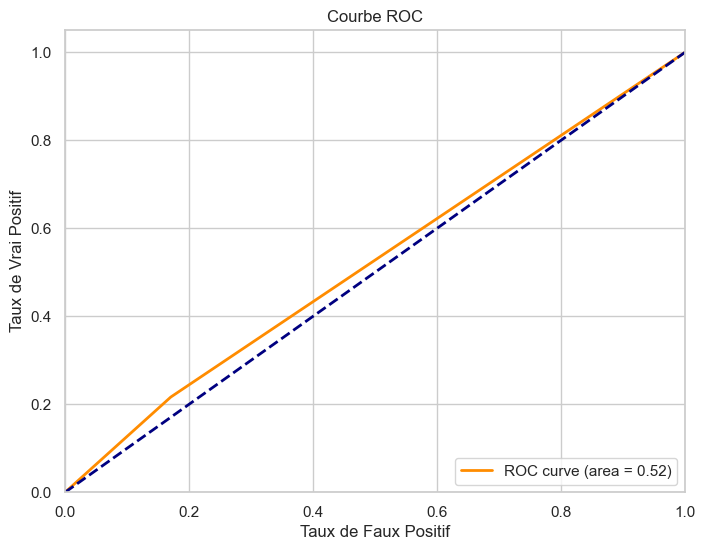

In [71]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()